# Part 2: Data Exploration

This notebook does some basic **exploratory data analysis** (EDA) of the finco churn data.
Here, we get a qualitative and a quantitative sense of the data,
what kind of cleanup it might need before we can use it,
and if there are any specific patterns that can be discerned.

If you haven't yet, run through the initialization steps in the README file and Part 1.
In Part 1, the data is imported into the `default.finco_churn` table in Hive.
All new data accesses will fetch from Hive.

## Load data

We start by creating a `SparkSession` to fetch the data using Spark SQL.

In [1]:
from pyspark.sql import SparkSession

# connect to Spark
spark = SparkSession\
    .builder\
    .appName("Telco Data Set")\
    .master("local[*]") \
    .getOrCreate()

finco_data_raw = spark.sql("SELECT * FROM default.finco_churn")  # read data into a Spark DataFrame
finco_data_raw.toPandas().head()  # print a few rows

CustomerID  Gender SeniorCitizen Partner Dependents  Tenure SavingsAccount  \
0  7590-VHVEG  Female             0     Yes         No     1.0           No   
1  5575-GNVDE    Male             0      No         No    34.0          Yes   
2  3668-QPYBK    Male             0      No         No     2.0          Yes   
3  7795-CFOCW    Male             0      No         No    45.0           No   
4  9237-HQITU  Female             0      No         No     2.0          Yes   

      MultipleAccounts VirtualWallet OverdraftProtection  ... OnlineBillPay  \
0  No Savings Account             Virtual Wallet             No  ...               No   
1                No             Virtual Wallet            Yes  ...              Yes   
2                No             Virtual Wallet            Yes  ...               No   
3  No Savings Account             Virtual Wallet            Yes  ...              Yes   
4                No     Virtual Wallet with Performance Spend             No  ...               No   

  EmailAlerts TextAlerts Rewards        Engagement PaperlessStatements  \
0          No          No              No  Weekly              Yes   
1          No          No              No        Monthly               No   
2          No          No              No  Weekly              Yes   
3         Yes          No              No        Monthly               No   
4          No          No              No  Weekly              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

## Analysis using Spark DataFrames

Spark Dataframes essentially allow you to express SQL-like statements with the horizontal scalability of Spark. 
You can perform your familiar filter, count, groupby etc. 

For more, see the [official Spark Documentation](http://spark.apache.org/docs/latest/sql-programming-guide.html).

We demonstrate some high-level stats and basic aggregations you might do to get an initial sense of the data.

In [2]:
# total number of customers in the dataset
finco_data_raw.count()

7043

In [3]:
# count of customers by internet service type 
finco_data_raw.groupby("VirtualWallet")\
              .count()\
              .show()

+---------------+-----+
|VirtualWallet|count|
+---------------+-----+
|           null|   11|
|    Virtual Wallet with Performance Spend| 3096|
|             No| 1520|
|            Virtual Wallet| 2416|
+---------------+-----+



### Create Temporary Spark Table

Using the `createOrReplaceTempView` functions allows you register a temporary table (called a view) in Spark.
This lets you use SQL syntax to make the queries instead of the method chaining we used in the last statement.


In [4]:
finco_data_raw.createOrReplaceTempView("finco")
spark.sql("SELECT Churn, count(*) FROM finco GROUP BY Churn").show()

+-----+--------+
|Churn|count(1)|
+-----+--------+
| null|      11|
|   No|    5163|
|  Yes|    1869|
+-----+--------+



As you can see, there are 11 null values in the `Churn` column,
which is the label column telling us whether the customer churned or not.
We'll have to clean the rows with those nulls out since we don't know their true labels.

In [5]:
finco_data = finco_data_raw.filter(finco_data_raw.Churn.isNotNull())

In [6]:
total_customers = finco_data.count()
churned_customers = finco_data.filter(finco_data.Churn == 'Yes').count()
remain_customers = finco_data.filter(finco_data.Churn == 'No').count()

"Customers total: {}, Churned : {}, Remained : {}".format(total_customers, churned_customers, remain_customers)

'Customers total: 7032, Churned : 1869, Remained : 5163'

## Data visualisation

Exploratory data analysis usually involves a fair bit of data visualization. 
The workflow for large data sets is usually:

* [Take a sample](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sample) of the data so it fits in memory on a single machine.
* Examine single variable distributions.
* Examine joint distributions and correlations.
* Look for other types of relationships.

We start with taking a 50% sample and saving it in a pandas DataFrame to feed into our visualizations.

In [7]:
# Note: toPandas() => brings data locally into a Pandas DataFrame
sample_data = finco_data.sample(withReplacement=False, fraction=0.5, seed=83).toPandas()
sample_data.head().T  # transpose for easier reading

0             1               2  \
CustomerID              7590-VHVEG    5575-GNVDE      3668-QPYBK   
Gender                      Female          Male            Male   
SeniorCitizen                    0             0               0   
Partner                        Yes            No              No   
Dependents                      No            No              No   
Tenure                           1            34               2   
SavingsAccount                    No           Yes             Yes   
MultipleAccounts     No Savings Account            No              No   
VirtualWallet                Virtual Wallet           Virtual Wallet             Virtual Wallet   
OverdraftProtection                  No           Yes             Yes   
AccountTransfer                   Yes            No             Yes   
OnlineBillPay                No           Yes              No   
EmailAlerts                     No            No              No   
TextAlerts                     No            No              No   
Rewards                 No            No              No   
Engagement            Weekly      Monthly  Weekly   
PaperlessStatements               Yes            No             Yes   
PaymentMethod     Electronic check  Mailed check    Mailed check   
MonthlyCharges               29.85         56.95           53.85   
TotalCharges                 29.85        1889.5          108.15   
Churn                           No            No             Yes   

                                 3                 4  
CustomerID              9237-HQITU        9305-CDSKC  
Gender                      Female            Female  
SeniorCitizen                    0                 0  
Partner                         No                No  
Dependents                      No                No  
Tenure                           2                 8  
SavingsAccount                   Yes               Yes  
MultipleAccounts                   No               Yes  
VirtualWallet        Virtual Wallet with Performance Spend       Virtual Wallet with Performance Spend  
OverdraftProtection                  No                No  
AccountTransfer                    No                No  
OnlineBillPay                No               Yes  
EmailAlerts                     No                No  
TextAlerts                     No               Yes  
Rewards                 No               Yes  
Engagement            Weekly    Weekly  
PaperlessStatements               Yes               Yes  
PaymentMethod     Electronic check  Electronic check  
MonthlyCharges                70.7             99.65  
TotalCharges                151.65             820.5  
Churn                          Yes               Yes

### Feature distributions (and installing packages)

We want to examine the distribution of our features, so start with them one at a time.

Let's use seaborn's [distplot() function](https://seaborn.pydata.org/generated/seaborn.distplot.html) to easily examine the distribution of a column.

In the initialisation step when you run `0_bootstrap.py` file, the python requirements are installed. If you have not run that step yet, and seaborn is not installed, you can [**install it and other python packages**](https://docs.cloudera.com/machine-learning/cloud/engines/topics/ml-install-pkg-lib.html) now. 

> Navigate to your Project's **Overview** page. Click **Open Workbench** and launch a session.
> Install using the `!` shell operator: 
> 
> `!pip3 install seaborn`. 
> 
> This is also how you would install from a `requirements.txt` file:
> 
> `!pip3 install -r requirements.txt`
> 

These packages will be available to all scripts and notebooks in the Project, 
similar to installing a repo's `requirements.txt` dependencies into a *virtualenv*.

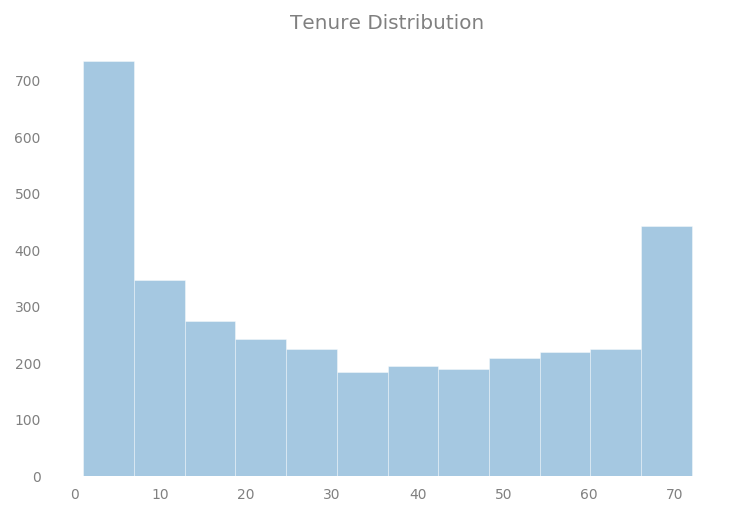

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.grid(b=None)
plt.title("Tenure Distribution",color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')

sns.set_style("whitegrid")
sns.despine(left=True,bottom=True)

sns.distplot(sample_data['Tenure'], kde=False, axlabel=False)


<div style="width:640px;font-size:16px;background-color:WhiteSmoke;padding:15px">

We can examine feature differences in the distribution of our features when we condition (split) our data.
We'll use [seaborn's BoxPlot function](https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn.boxplot) for this, 
though we could have also use many other functions or entirely different packages.

<div>

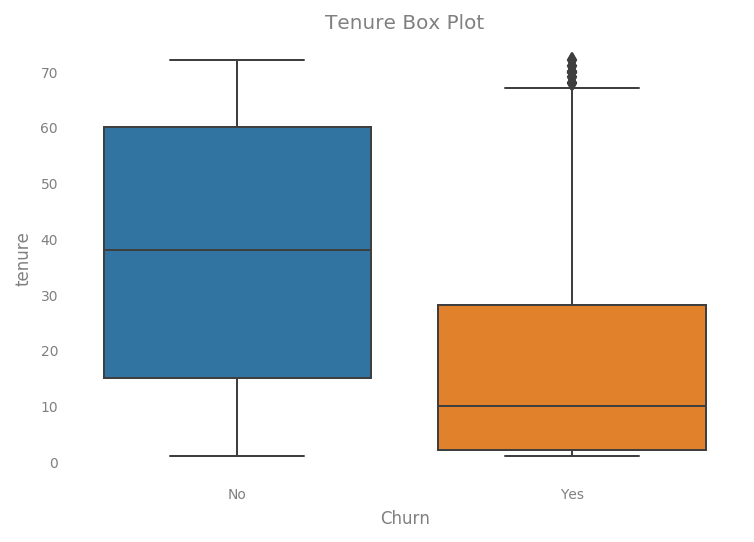

In [9]:
plt.grid(b=None)
plt.title("Tenure Box Plot",color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')
plt.xlabel("",color='grey')
plt.ylabel("",color='grey')

sns.set_style("whitegrid")
sns.despine(left=True,bottom=True)

sns.boxplot(x="Churn", y="Tenure", data=sample_data)

In these examples, we only examined one column,
but a complete analysis would examine all the rest for data quality issues or potentially useful or useless features.

## Joint Distributions
Looking at joint distributions of data can also tell us a lot, particularly about duplicated features that need removing.
[Seaborn's PairPlot](https://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) is a quick way to look at joint distributions for many variables at once.
Note that it may struggle with a large number of columns, so we demonstrate with three.

In [10]:
sns.set_style("whitegrid")
example_numeric_data = sample_data[["MonthlyCharges", "TotalCharges","Tenure","Churn"]]  # pick a few columns
sns.pairplot(example_numeric_data, hue="Churn")

## Stop the Spark session
Jupyter Notebooks stake longer to timeout than regular workbench sessions, so its good practice to add a `spark.stop()` call in you notebook to make sure any spark resources are added back to the cluster if you aren't using them.

In [11]:
spark.stop()

## Wrap up
We've now covered a quick **exploratory data analysis** using Spark SQL, Spark DataFrames, and seaborn.
We've also explained how to **install packages** in a CML Project.
This is just a taste, and you can install any of your favorite packages—even custom ones—to dig even further.